In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length

def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xtest, Ytest = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [55]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vector
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [60]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # (batch_size, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # tracking
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


In [63]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size, n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0357086658477783
val 2.1029491424560547


In [64]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = [] 
    context = [0] * block_size
    while True:
        # forward of the nn
        emb = C[torch.tensor(context)] # (1,block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the prob distribution 
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special token '.', break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.


First problem: wrongly confidence of the model to predict.

In training, it is almost the case you will have a rough idea of what loss to expect

Depends on loss function and problem setup

In [16]:
# expected loss - uniform distribution assigning equal probs to 27 characters
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [21]:
# 4 dimensional example of the issue
logits = torch.randn(4)
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-0.5790,  0.3769,  1.4683, -0.4619]),
 tensor([0.0802, 0.2085, 0.6211, 0.0901]),
 tensor(0.4762))

Second problem: tanh saturated

tanh is a squashing function, that takes arbitrary values and arrange them into a -1 and 1 values.

During backpropagation, calculating tanh derivative if t=0, gradient just passes through, but if it gets 1, you kill the neuron.

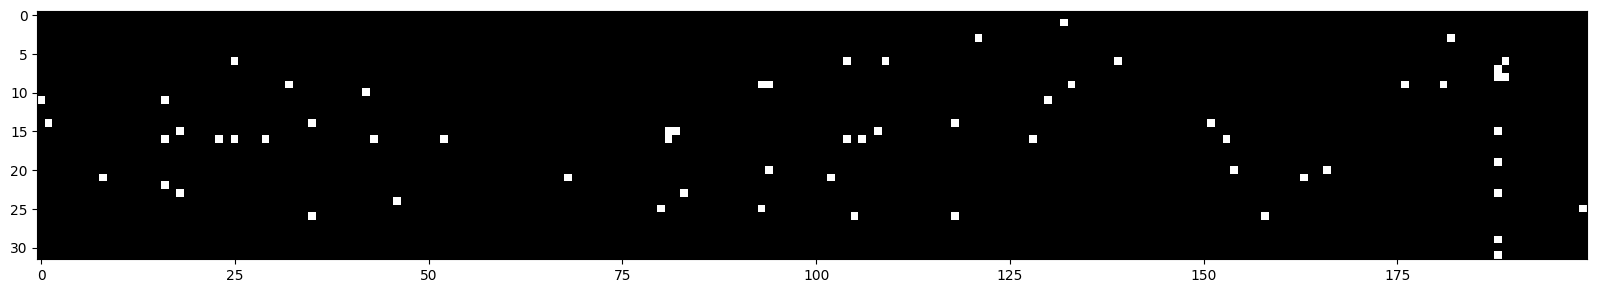

In [59]:
# take a look if h in the absolute value how ofter is in the flat region of tanh
# boolean tensor, white for true/ black for false
# for any of the columns(neurons) is white, would be a dead neuron
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

How to assign the initial scales to assign the parameters?

tensor(-0.0041) tensor(1.0060)
tensor(-0.0168) tensor(0.9829)


(array([1.45466221e-05, 3.63665552e-05, 3.63665552e-05, 1.38192910e-04,
        2.54565886e-04, 2.90932442e-04, 6.61871304e-04, 1.06917672e-03,
        1.80378114e-03, 2.78567813e-03, 4.52399947e-03, 7.60061003e-03,
        1.12445389e-02, 1.65758759e-02, 2.47728974e-02, 3.45918673e-02,
        4.72401552e-02, 6.34450922e-02, 8.28066462e-02, 1.02590052e-01,
        1.18911362e-01, 1.32483361e-01, 1.37036453e-01, 1.33188872e-01,
        1.20875156e-01, 1.04190181e-01, 8.49522729e-02, 6.36996581e-02,
        4.88693769e-02, 3.50355393e-02, 2.54056755e-02, 1.70486411e-02,
        1.10917993e-02, 7.18603131e-03, 4.77856535e-03, 2.91659773e-03,
        1.87651425e-03, 1.03281017e-03, 7.41877726e-04, 3.63665552e-04,
        2.47292575e-04, 1.09099666e-04, 5.81864883e-05, 2.90932442e-05,
        7.27331104e-06, 2.18199331e-05, 1.45466221e-05, 0.00000000e+00,
        0.00000000e+00, 7.27331104e-06]),
 array([-15.49366856, -14.80622374, -14.11877892, -13.4313341 ,
        -12.74388927, -12.0564

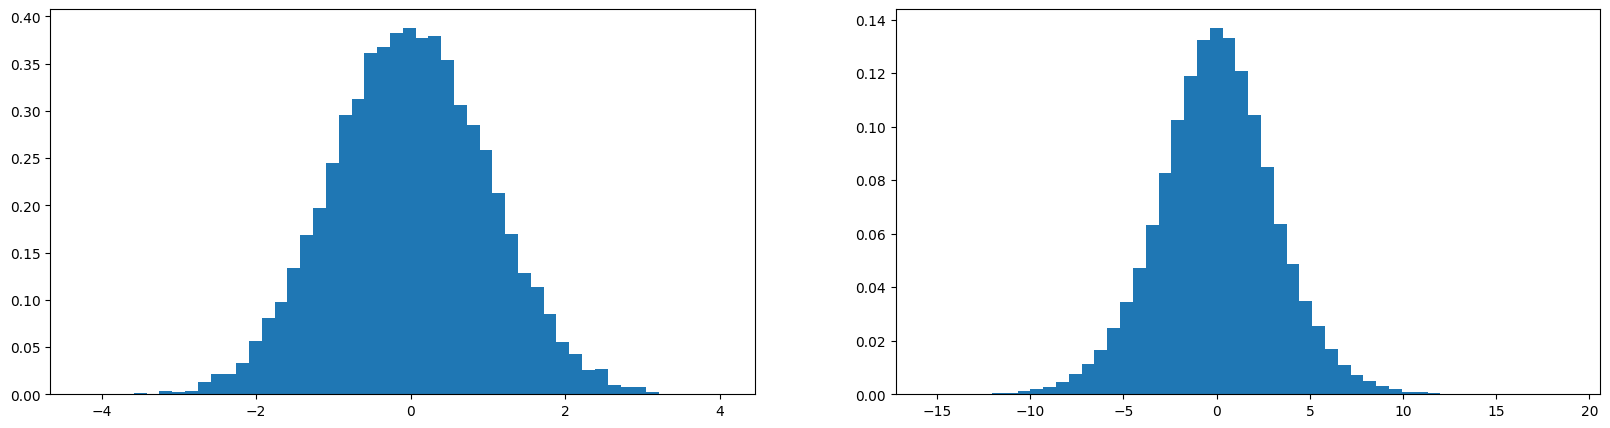

In [65]:
x = torch.randn(1000,10)
w = torch.randn(10,200)
y = x @ w
print(x.mean(), x.std())
print(w.mean(), w.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)